<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/DIST_GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt



In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [14]:


def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [15]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [16]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        c =64
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=128)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [17]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(x) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits

# DIST-GAN Network 

---

1. Autoencoder optimization $\min_{A}  \Big({\rm BCE}\left((x_{\rm real}),\underbrace{X_r{\rm recon}}_{1}\right) + {\rm BCE}\left(G(\underbrace{x_{\rm fake}}_{G[z]}),\underbrace{X_f{\rm fake}}_0\right)\Big)
$


2. Generator optimization $\min_{G}  ~{\rm BCE}\left(D(\underbrace{X_f{\rm fake}}_{G[z]}),\underbrace{X_r{\rm real}}_1\right)$

<font color=red>The generator tries to assign $D(x_{\rm fake}) \rightarrow 1$ </font>.




In [44]:

from torch.autograd import grad as torch_grad
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        #print(data.shape[0])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder().cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function Hinge Embedding loss ( from paper )
       
        self.BCE = nn.BCEWithLogitsLoss().cuda()
     
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
                #x_ = x_.view(x_.size(0), -1)
               # z_ = z_.view(z_.size(0), -1)
                x_, z_ = x_.cuda() ,z_.cuda()
        
        

                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularization

                torch.autograd.set_detect_anomaly(True)
                # reconstructed image
                recon = self.A(x_)
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f

                D_real_prob, D_real_logits = self.D(x_)
                D_recon_prob, D_recon_logits= self.D(X_r)
                D_fake_prob, D_fake_logits = self.D(X_f)


                ## auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real_prob-D_recon_prob))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon_prob - D_fake_prob) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                g = torch.mean(recon - z_) * 0.8838  # distance between reconstruced imgs and noise
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                
                # train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                self.A_optimizer.zero_grad()
                R_loss.backward(retain_graph=True)
                self.A_optimizer.step()

                D_real_prob, D_real_logits = self.D(x_.detach())
                D_recon_prob, D_recon_logits= self.D(X_r.detach())
                D_fake_prob, D_fake_logits = self.D(X_f.detach())


                #train Generator with G_Loss 
                self.G_optimizer.zero_grad()
               
                G_loss = torch.abs(torch.mean(D_recon_prob)- torch.mean(D_fake_prob))
                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######

                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits = self.D(x_.detach())
                D_recon_prob, D_recon_logits= self.D(X_r.detach())
                D_fake_prob, D_fake_logits = self.D(X_f.detach())


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits = self.D(interpolation)
                # Gradien Penalty 
                gradients = torch_grad(d_inter_prob, interpolation, grad_outputs=torch.ones(d_inter_prob.size()).cuda())[0]
              
                slopes = torch.square(torch.mean(torch.square(gradients)))
                gp = torch.mean((slopes-1)**2)
            
 
            
                # Discriminator loss on data
                d_loss_real = torch.mean(self.BCE( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(self.BCE(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(self.BCE(D_fake_logits,torch.zeros_like(D_fake_prob)))

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

          
              
                #train Discriminator 
                self.D_optimizer.zero_grad()
                D_loss.backward(retain_graph=True)
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                

                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits = self.D(x_.detach())
                D_recon_prob, D_recon_logits= self.D(X_r.detach())
                D_fake_prob, D_fake_logits = self.D(X_f.detach())
             
                self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))
                G_loss.backward(retain_graph=True)
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
    
                      # Visualize results
            with torch.no_grad():
              visualize_results(self)
            if epoch== 10:  
           

              print('Generator Reconstruction Images at 10 Epoch')
              visualise_output(self)
            
            if epoch   == 20:  
          

              print('Generator Reconstruction Images at 20 Epoch')
              visualise_output(self)
            if epoch  == 30:  
           

              print('Generator Reconstruction Images at 30 Epoch')
              visualise_output(self)
            if epoch  == 40:  
            

              print('Generator Reconstruction Images at 40 Epoch')
              visualise_output(self)

        print("Training finished!")

In [42]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  with torch.no_grad():
    z = torch.rand((gan.base_size, gan.z_dim)).cuda()
    z = gan.G(z)
    z = z.cpu()
    unique, counts = np.unique(z, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.xlabel("Label")
    plt.ylabel("Quantity")
    plt.title("Labels in MNIST 784 dataset")

training start!!
Epoch: [ 1] [  50/ 200] D_loss: 2.79758072, G_loss: 0.07868034
Epoch: [ 1] [ 100/ 200] D_loss: 2.64510155, G_loss: 0.14252245
Epoch: [ 1] [ 150/ 200] D_loss: 2.44829488, G_loss: 0.20928198
Epoch: [ 1] [ 200/ 200] D_loss: 2.19595408, G_loss: 0.32574174


<Figure size 72x720 with 0 Axes>

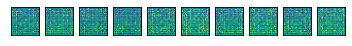

Epoch: [ 2] [  50/ 200] D_loss: 2.08621764, G_loss: 0.37678656
Epoch: [ 2] [ 100/ 200] D_loss: 1.93010533, G_loss: 0.45038158
Epoch: [ 2] [ 150/ 200] D_loss: 1.91948676, G_loss: 0.50686938
Epoch: [ 2] [ 200/ 200] D_loss: 1.59187186, G_loss: 0.65354717


<Figure size 72x720 with 0 Axes>

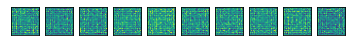

Epoch: [ 3] [  50/ 200] D_loss: 1.44988692, G_loss: 0.71227574
Epoch: [ 3] [ 100/ 200] D_loss: 1.68729889, G_loss: 0.68048531
Epoch: [ 3] [ 150/ 200] D_loss: 1.26686907, G_loss: 0.80605036
Epoch: [ 3] [ 200/ 200] D_loss: 1.24319243, G_loss: 0.84696084


<Figure size 72x720 with 0 Axes>

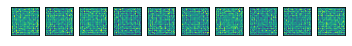

Epoch: [ 4] [  50/ 200] D_loss: 1.18720531, G_loss: 0.87467903
Epoch: [ 4] [ 100/ 200] D_loss: 1.17256439, G_loss: 0.89331174
Epoch: [ 4] [ 150/ 200] D_loss: 1.13197923, G_loss: 0.91257215
Epoch: [ 4] [ 200/ 200] D_loss: 1.12881410, G_loss: 0.92085779


<Figure size 72x720 with 0 Axes>

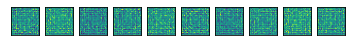

Epoch: [ 5] [  50/ 200] D_loss: 1.10851264, G_loss: 0.93192601
Epoch: [ 5] [ 100/ 200] D_loss: 1.07423329, G_loss: 0.94756240
Epoch: [ 5] [ 150/ 200] D_loss: 1.06495786, G_loss: 0.95476872
Epoch: [ 5] [ 200/ 200] D_loss: 1.06072056, G_loss: 0.95524102


<Figure size 72x720 with 0 Axes>

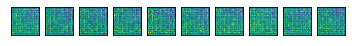

Epoch: [ 6] [  50/ 200] D_loss: 1.05113292, G_loss: 0.96229577
Epoch: [ 6] [ 100/ 200] D_loss: 1.05798090, G_loss: 0.96341658
Epoch: [ 6] [ 150/ 200] D_loss: 1.04865420, G_loss: 0.96759361
Epoch: [ 6] [ 200/ 200] D_loss: 1.04004681, G_loss: 0.97327358


<Figure size 72x720 with 0 Axes>

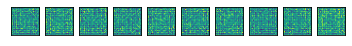

Epoch: [ 7] [  50/ 200] D_loss: 1.28051591, G_loss: 0.86147392
Epoch: [ 7] [ 100/ 200] D_loss: 1.13320017, G_loss: 0.92507845
Epoch: [ 7] [ 150/ 200] D_loss: 1.08612847, G_loss: 0.94788384
Epoch: [ 7] [ 200/ 200] D_loss: 1.05952930, G_loss: 0.96016854


<Figure size 72x720 with 0 Axes>

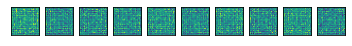

Epoch: [ 8] [  50/ 200] D_loss: 1.05367744, G_loss: 0.96339774


KeyboardInterrupt: ignored

In [45]:
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':100}
params['z_dim'] = 128
params['base_size'] = 64

gan = GAN(params)


gan.train()